In [18]:
import math
import numpy as np
import pandas as pd

# import scikitplot
import seaborn as sns
from matplotlib import pyplot

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report

import tensorflow as tf
from tensorflow.keras import optimizers
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Flatten, Dense, Conv2D, MaxPooling2D
from tensorflow.keras.layers import Dropout, BatchNormalization, LeakyReLU, Activation
from tensorflow.keras.callbacks import Callback, EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from keras.utils import to_categorical

import np_utils

In [19]:
df = pd.read_csv(r'C:\Users\cig79850\Deep_Learning_Class\main_project\challenges-in-representation-learning-facial-expression-recognition-challenge\icml_face_data.csv')
print(df.shape) # (35887, 3)

df.head()

(35887, 3)


,emotion,Usage,pixels
0,0,Training,70 80 82 72 58 58 60 63 54 58 60 48 89 115 121...
1,0,Training,151 150 147 155 148 133 111 140 170 174 182 15...
2,2,Training,231 212 156 164 174 138 161 173 182 200 106 38...
3,4,Training,24 32 36 30 32 23 19 20 30 41 21 22 32 34 21 1...
4,6,Training,4 0 0 0 0 0 0 0 0 0 0 0 3 15 23 28 48 50 58 84...


In [20]:
df.emotion.unique() # array([0, 2, 4, 6, 3, 5, 1])

df.emotion.value_counts()

# sns.countplot(df.emotion)
# pyplot.show()

emotion
3    8989
6    6198
4    6077
2    5121
0    4953
5    4002
1     547
Name: count, dtype: int64

In [21]:
df.columns

Index(['emotion', 'Usage', 'pixels'], dtype='object')

In [22]:
emotion_label_to_text = {
  0: 'anger',
  1: 'disgust',
  2: 'fear',
  3: 'happiness',
  4: 'sadness',
  5: 'surprise',
  6: 'neutral'
}

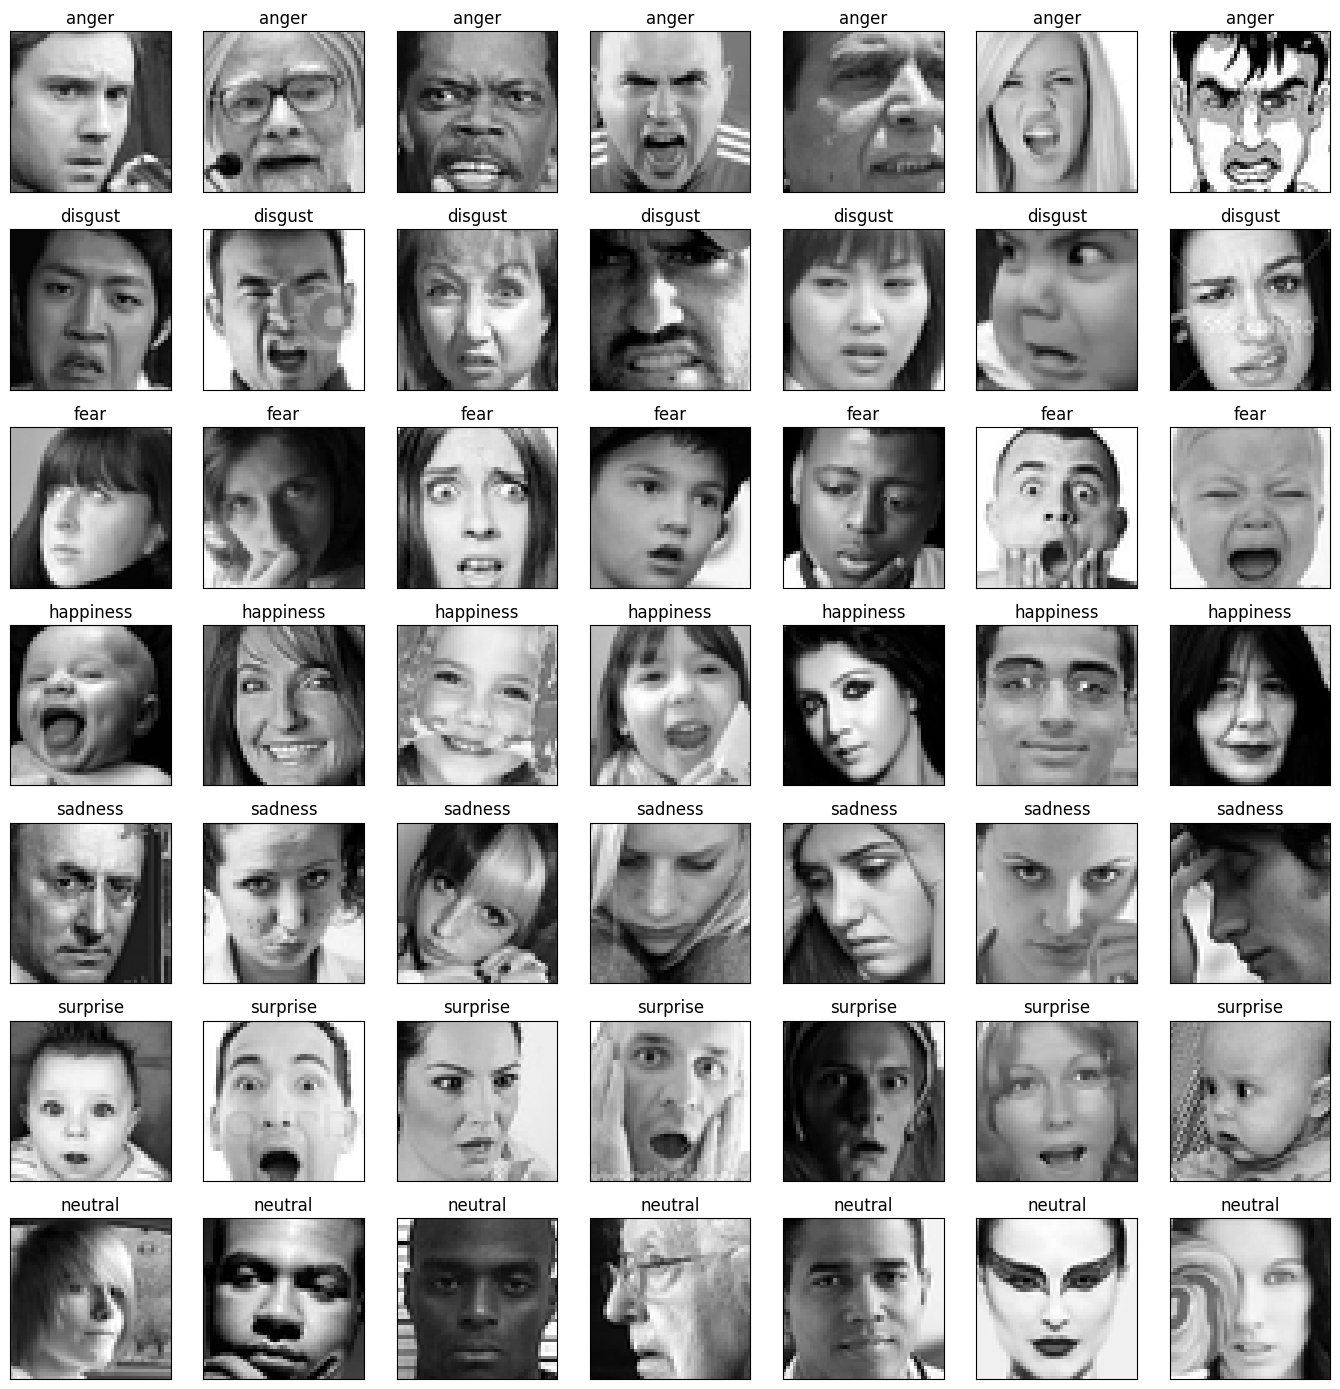

In [23]:
fig = pyplot.figure(1, (14, 14))

k = 0
for label in sorted(df.emotion.unique()):
    for j in range(7):
        px = df[df.emotion==label].pixels.iloc[k]
        px = np.array(px.split(' ')).reshape(48, 48).astype('float32')

        k += 1
        ax = pyplot.subplot(7, 7, k)
        ax.imshow(px, cmap='gray')
        ax.set_xticks([])
        ax.set_yticks([])
        ax.set_title(emotion_label_to_text[label])
        pyplot.tight_layout()

In [24]:
# INTERESTED_LABELS = [3, 4, 6]

# df = df[df.emotion.isin(INTERESTED_LABELS)]
# df.shape # (21264, 3)

In [25]:
img_array = df.pixels.apply(lambda x: np.array(x.split(' ')).reshape(48, 48, 1).astype('float32'))
img_array = np.stack(img_array, axis=0)
img_array.shape # (21264, 48, 48, 1)

le = LabelEncoder()
img_labels = le.fit_transform(df.emotion)
img_labels = to_categorical(img_labels)
img_labels.shape # (21264, 3)

le_name_mapping = dict(zip(le.classes_, le.transform(le.classes_)))
le_name_mapping # {3: 0, 4: 1, 6: 2}

{0: 0, 1: 1, 2: 2, 3: 3, 4: 4, 5: 5, 6: 6}

In [26]:
X_train, X_valid, y_train, y_valid = train_test_split(
  img_array,
  img_labels,
  shuffle=True, 
  stratify=img_labels,
  test_size=0.1, 
  random_state=42
)

del df
del img_array
del img_labels

print(X_train.shape, X_valid.shape, y_train.shape, y_valid.shape)

# OUTPUT
'''
((19137, 48, 48, 1), (2127, 48, 48, 1), (19137, 3), (2127, 3))
'''

(32298, 48, 48, 1) (3589, 48, 48, 1) (32298, 7) (3589, 7)


'\n((19137, 48, 48, 1), (2127, 48, 48, 1), (19137, 3), (2127, 3))\n'

In [27]:
# Normalizing arrays, as neural networks are very sensitive to unnormalized data.
X_train = X_train / 255.
X_valid = X_valid / 255.

img_width = X_train.shape[1]
img_height = X_train.shape[2]
img_depth = X_train.shape[3]
num_classes = y_train.shape[1]

In [28]:
def cnn_alex(input_shape, num_classes):
    tf.random.set_seed(42)
    model = Sequential()
    
    model.add(Conv2D(96, input_shape=input_shape, kernel_size=(11, 11), strides=(4, 4), activation='relu', padding='same'))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))  # Adjusted pooling size
    
    model.add(Conv2D(256, kernel_size=(5, 5), padding='same', activation='relu'))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))  # Adjusted pooling size
    
    model.add(Conv2D(384, kernel_size=(3, 3), padding='same', activation='relu'))
    model.add(Conv2D(384, kernel_size=(3, 3), padding='same', activation='relu'))
    model.add(Conv2D(256, kernel_size=(3, 3), padding='same', activation='relu'))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))  # Adjusted pooling size
    
    model.add(Flatten())
    model.add(Dense(4096, activation='relu'))
    model.add(Dropout(rate=0.5))
    model.add(Dense(4096, activation='relu'))
    model.add(Dropout(rate=0.5))
    model.add(Dense(num_classes, activation='softmax'))
    
    model.compile(
        loss='categorical_crossentropy',
        optimizer=tf.keras.optimizers.RMSprop(learning_rate=0.001),
        metrics=['accuracy']
    )
    
    return model


In [29]:
# def build_net(optim):
#     net = Sequential(name='DCNN')

#     net.add(
#         Conv2D(
#             filters=64,
#             kernel_size=(5,5),
#             input_shape=(img_width, img_height, img_depth),
#             activation='elu',
#             padding='same',
#             kernel_initializer='he_normal',
#             name='conv2d_1'
#         )
#     )
#     net.add(BatchNormalization(name='batchnorm_1'))
#     net.add(
#         Conv2D(
#             filters=64,
#             kernel_size=(5,5),
#             activation='elu',
#             padding='same',
#             kernel_initializer='he_normal',
#             name='conv2d_2'
#         )
#     )
#     net.add(BatchNormalization(name='batchnorm_2'))
    
#     net.add(MaxPooling2D(pool_size=(2,2), name='maxpool2d_1'))
#     net.add(Dropout(0.4, name='dropout_1'))

#     net.add(
#         Conv2D(
#             filters=128,
#             kernel_size=(3,3),
#             activation='elu',
#             padding='same',
#             kernel_initializer='he_normal',
#             name='conv2d_3'
#         )
#     )
#     net.add(BatchNormalization(name='batchnorm_3'))
#     net.add(
#         Conv2D(
#             filters=128,
#             kernel_size=(3,3),
#             activation='elu',
#             padding='same',
#             kernel_initializer='he_normal',
#             name='conv2d_4'
#         )
#     )
#     net.add(BatchNormalization(name='batchnorm_4'))
    
#     net.add(MaxPooling2D(pool_size=(2,2), name='maxpool2d_2'))
#     net.add(Dropout(0.4, name='dropout_2'))

#     net.add(
#         Conv2D(
#             filters=256,
#             kernel_size=(3,3),
#             activation='elu',
#             padding='same',
#             kernel_initializer='he_normal',
#             name='conv2d_5'
#         )
#     )
#     net.add(BatchNormalization(name='batchnorm_5'))
#     net.add(
#         Conv2D(
#             filters=256,
#             kernel_size=(3,3),
#             activation='elu',
#             padding='same',
#             kernel_initializer='he_normal',
#             name='conv2d_6'
#         )
#     )
#     net.add(BatchNormalization(name='batchnorm_6'))
    
#     net.add(MaxPooling2D(pool_size=(2,2), name='maxpool2d_3'))
#     net.add(Dropout(0.5, name='dropout_3'))

#     net.add(Flatten(name='flatten'))
        
#     net.add(
#         Dense(
#             128,
#             activation='elu',
#             kernel_initializer='he_normal',
#             name='dense_1'
#         )
#     )
#     net.add(BatchNormalization(name='batchnorm_7'))
    
#     net.add(Dropout(0.6, name='dropout_4'))
    
#     net.add(
#         Dense(
#             num_classes,
#             activation='softmax',
#             name='out_layer'
#         )
#     )
    
#     net.compile(
#         loss='categorical_crossentropy',
#         optimizer=optim,
#         metrics=['accuracy']
#     )
    
#     net.summary()
    
#     return net

In [30]:
early_stopping = EarlyStopping(
    monitor='val_accuracy',
    min_delta=0.00005,
    patience=11,
    verbose=1,
    restore_best_weights=True,
)

lr_scheduler = ReduceLROnPlateau(
    monitor='val_accuracy',
    factor=0.5,
    patience=7,
    min_lr=1e-7,
    verbose=1,
)

callbacks = [
    early_stopping,
    lr_scheduler,
]

In [31]:
train_datagen = ImageDataGenerator(
    rotation_range=15,
    width_shift_range=0.15,
    height_shift_range=0.15,
    shear_range=0.15,
    zoom_range=0.15,
    horizontal_flip=True,
)

train_datagen.fit(X_train)

In [32]:
batch_size = 32 #batch size of 32 performs the best.

epochs = 10

# optims = [
#   optimizers.Nadam(
#       learning_rate=0.001,
#       beta_1=0.9,
#       beta_2=0.999,
#       epsilon=1e-07,
#       name='Nadam'),
    
#   optimizers.Adam(0.001),
# ]

In [33]:
# Assuming you have img_width, img_height, img_depth, and num_classes defined

# Build AlexNet model
alexnet_model = cnn_alex((img_width, img_height, img_depth), num_classes)

# Train the model
history = alexnet_model.fit(
    train_datagen.flow(X_train, y_train, batch_size=batch_size),
    validation_data=(X_valid, y_valid),
    steps_per_epoch=len(X_train) / batch_size,
    epochs=epochs,
    callbacks=callbacks
)

Epoch 1/10


1009/1009 [==============================] - 121s 118ms/step - loss: 1.8431 - accuracy: 0.2418 - val_loss: 1.7994 - val_accuracy: 0.2616 - lr: 0.0010
Epoch 2/10
1009/1009 [==============================] - 120s 119ms/step - loss: 1.7617 - accuracy: 0.2806 - val_loss: 1.7360 - val_accuracy: 0.3082 - lr: 0.0010
Epoch 3/10
1009/1009 [==============================] - 120s 119ms/step - loss: 1.6996 - accuracy: 0.3204 - val_loss: 1.6181 - val_accuracy: 0.3831 - lr: 0.0010
Epoch 4/10
1009/1009 [==============================] - 126s 125ms/step - loss: 1.6600 - accuracy: 0.3443 - val_loss: 1.7334 - val_accuracy: 0.2962 - lr: 0.0010
Epoch 5/10
1009/1009 [==============================] - 124s 123ms/step - loss: 1.6320 - accuracy: 0.3555 - val_loss: 1.6344 - val_accuracy: 0.3597 - lr: 0.0010
Epoch 6/10
1009/1009 [==============================] - 118s 117ms/step - loss: 1.6121 - accuracy: 0.3680 - val_loss: 1.5447 - val_accuracy: 0.4152 - lr: 0.0010
Epoch 7/10
1009/1009 [==========

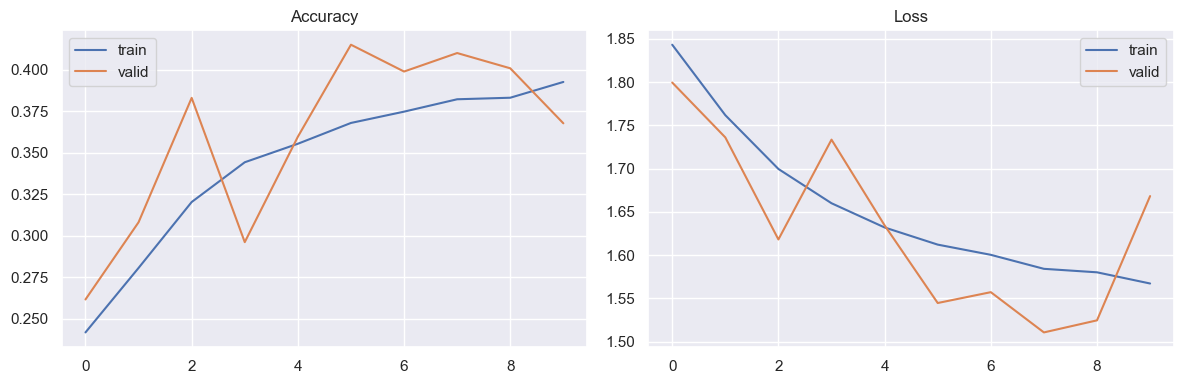

In [34]:
import matplotlib.pyplot as plt

sns.set()
fig, axes = plt.subplots(1, 2, figsize=(12, 4))

# Plot Accuracy
ax = axes[0]
sns.lineplot(x=history.epoch, y=history.history['accuracy'], ax=ax, label='train')
sns.lineplot(x=history.epoch, y=history.history['val_accuracy'], ax=ax, label='valid')
ax.set_title('Accuracy')

# Plot Loss
ax = axes[1]
sns.lineplot(x=history.epoch, y=history.history['loss'], ax=ax, label='train')
sns.lineplot(x=history.epoch, y=history.history['val_loss'], ax=ax, label='valid')
ax.set_title('Loss')

plt.tight_layout()
plt.savefig('epoch_history_dcnn.png')
plt.show()


In [36]:
import time
from keras.models import model_from_json

# Get timestamp
timestamp = time.strftime("%Y-%m-%d_%H-%M-%S")

# Save model architecture as JSON
model_json = alexnet_model.to_json()
json_filename = f"model_{timestamp}.json"
with open(json_filename, "w") as json_file:
    json_file.write(model_json)

# Save model weights
h5_filename = f"model_{timestamp}.h5"
alexnet_model.save_weights(h5_filename)

# Save entire model (architecture + weights)
alexnet_model.save(f"model_{timestamp}.h5")


C:\ProgramData\anaconda3\envs\dlenv\Lib\site-packages\keras\src\engine\training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


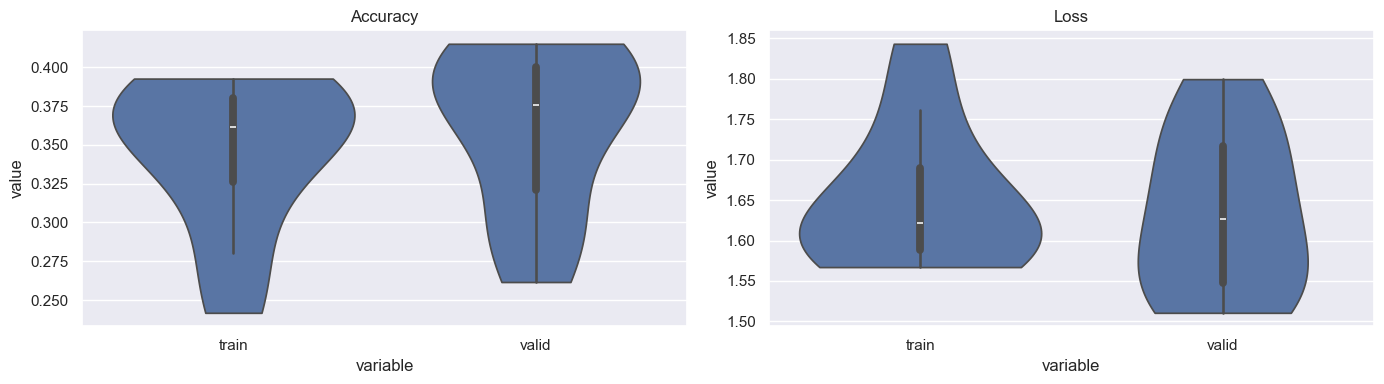

In [37]:
import time
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt

# Create DataFrames for accuracy and loss
df_accu = pd.DataFrame({'train': history.history['accuracy'], 'valid': history.history['val_accuracy']})
df_loss = pd.DataFrame({'train': history.history['loss'], 'valid': history.history['val_loss']})

# Get timestamp
timestamp = time.strftime("%Y-%m-%d_%H-%M-%S")

# Create violin plots for accuracy and loss
fig, axes = plt.subplots(1, 2, figsize=(14, 4))

sns.violinplot(x="variable", y="value", data=pd.melt(df_accu), cut=0, ax=axes[0])
axes[0].set_title('Accuracy')

sns.violinplot(x="variable", y="value", data=pd.melt(df_loss), cut=0, ax=axes[1])
axes[1].set_title('Loss')

plt.tight_layout()

# Save the plot
plt.savefig(f'performance_dist_{timestamp}.png')

# Show the plot
plt.show()


113/113 [==============================] - 2s 14ms/step


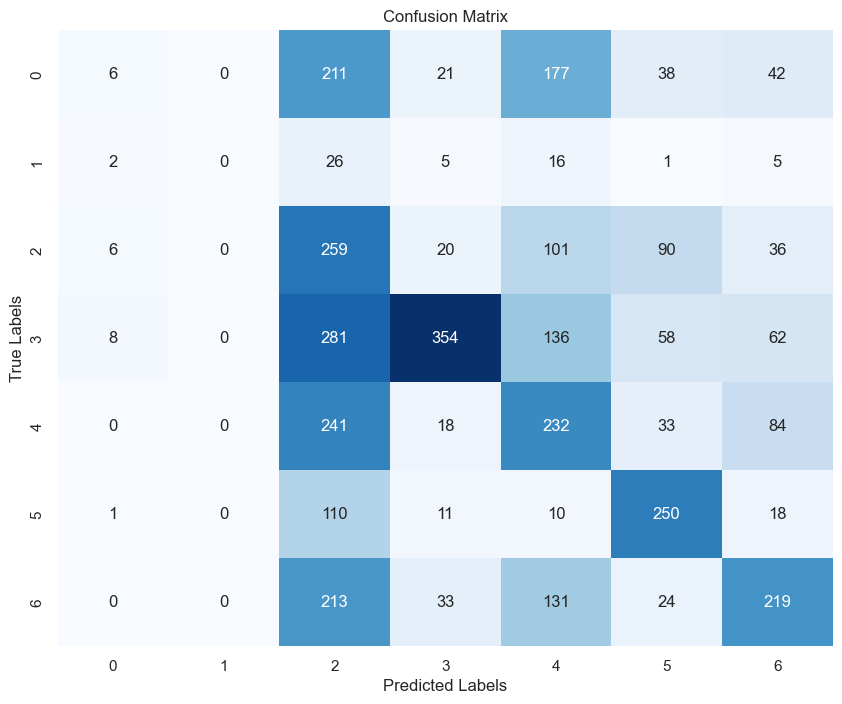

In [38]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

# Assuming you have predictions for the test set
y_pred = alexnet_model.predict(X_valid)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true = np.argmax(y_valid, axis=1)  # Assuming y_test is one-hot encoded

# Create confusion matrix
conf_mat = confusion_matrix(y_true, y_pred_classes)

# Plot confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(conf_mat, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.title('Confusion Matrix')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()

1/1 [==============================] - 0s 24ms/step


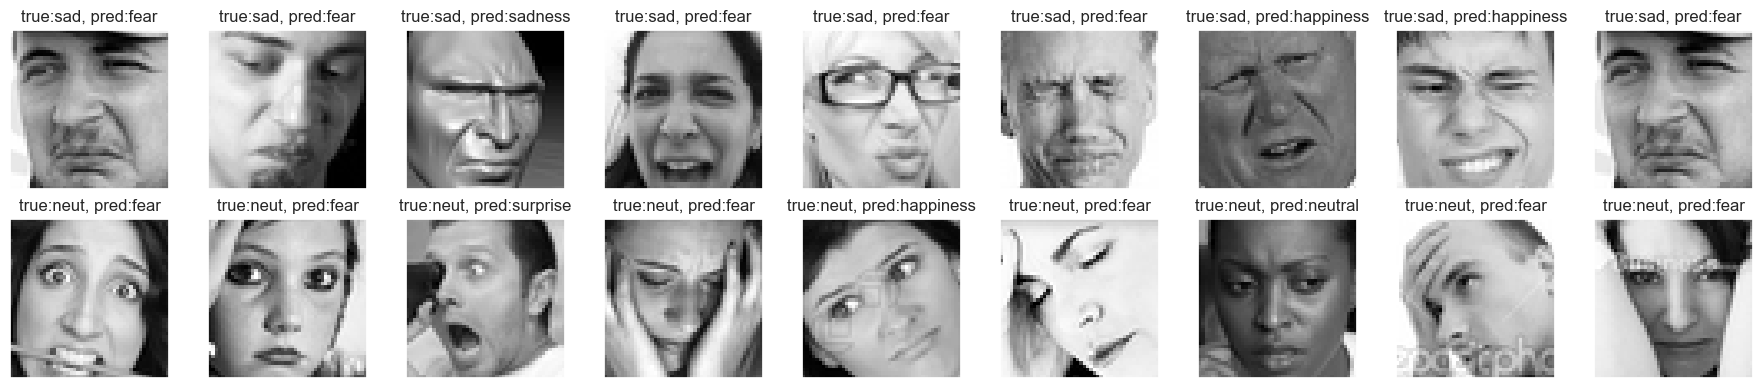

In [40]:
mapper = {
  0: 'anger',
  1: 'disgust',
  2: 'fear',
  3: 'happiness',
  4: 'sadness',
  5: 'surprise',
  6: 'neutral'
}

np.random.seed(2)
random_sad_imgs = np.random.choice(np.where(y_valid[:, 1]==1)[0], size=9)
random_neutral_imgs = np.random.choice(np.where(y_valid[:, 2]==1)[0], size=9)

fig = pyplot.figure(1, (18, 4))

for i, (sadidx, neuidx) in enumerate(zip(random_sad_imgs, random_neutral_imgs)):
    ax = pyplot.subplot(2, 9, i+1)
    sample_img = X_valid[sadidx,:,:,0]
    ax.imshow(sample_img, cmap='gray')
    ax.set_xticks([])
    ax.set_yticks([])
    
    # Predict probabilities for the current image
    pred_probs_sad = alexnet_model.predict(sample_img.reshape(1,48,48,1))
    
    # Select the class with the highest probability
    pred_label_sad = np.argmax(pred_probs_sad)
    
    ax.set_title(f"true:sad, pred:{mapper[pred_label_sad]}")

    ax = pyplot.subplot(2, 9, i+10)
    sample_img = X_valid[neuidx,:,:,0]
    ax.imshow(sample_img, cmap='gray')
    ax.set_xticks([])
    ax.set_yticks([])
    
    # Predict probabilities for the current image
    pred_probs_neut = alexnet_model.predict(sample_img.reshape(1,48,48,1))
    
    # Select the class with the highest probability
    pred_label_neut = np.argmax(pred_probs_neut)
    
    ax.set_title(f"true:neut, pred:{mapper[pred_label_neut]}")

pyplot.tight_layout()
